In [2]:
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from scipy.cluster.vq import vq
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

# Load the data

In [4]:
hmpLabels = ['Brush_teeth', 'Climb_stairs', 'Comb_hair', 'Descend_stairs', 'Drink_glass', 'Eat_meat', 'Eat_soup', 'Getup_bed', 'Liedown_bed',
             'Pour_water', 'Sitdown_chair', 'Standup_chair', 'Use_telephone', 'Walk']

In [307]:
def loadData(hmpLabels):
    hmpData = {}
    for label in hmpLabels:
        path = 'data/' + label + '/*.txt'
        files = glob.glob(path)
        hmpData[label] = []
        for file in files:
            fileData = pd.read_csv(file, sep=" ", header=None).values
            hmpData[label].append(fileData)   
            
    return hmpData

In [308]:
hmpData = loadData(hmpLabels)

# Segmentation

In [309]:
def segmentData(data, segmentSize):
    segmentSize = segmentSize * 3                     # Each reading is actually 3 numbers - need to account that in segmentation
    incompleteSegmentData = len(data) % segmentSize   # We need to truncate last x rows that don't make a complete segment
    data = data[:len(data) - incompleteSegmentData]
    dataArr = np.array(data)                          # Convert to numpy array to enable easier transformation
    dataArr = np.reshape(dataArr, (-1, segmentSize))  # Do the segmentation
    return dataArr

In [310]:
def segmentAndSplitData(trainSize, segmentSize, hmpData, hmpLabels, showOutput = True):
    if (showOutput):
        print ("Using segment size", segmentSize, "and train size", trainSize)
        print ('Segmenting classes')
    
    allTrainDataSegmented = []
    allTrainLabels = []
    allTrainFileIdentifiers = []
    allTestDataSegmented = []
    allTestLabels = []
    allTestFileIdentifiers = []
    uniqueTrainFileCtr = 0
    uniqueTestFileCtr = 0
    
    totalFilesAcrossClasses = 0
    totalTrainFilesAcrossClasses = 0
    totalTestFilesAcrossClasses = 0
    
    for hmpClass in hmpLabels: 
        totalFiles = len(hmpData[hmpClass])
        trainFiles = int(round(totalFiles * trainSize))
        testFiles = totalFiles - trainFiles
        if (showOutput):
            print (hmpClass, '| Total files:', totalFiles, '|', trainFiles, "training |", testFiles, "testing)")
        
        # Calculate totals for files across all classes
        totalFilesAcrossClasses = totalFilesAcrossClasses + totalFiles
        totalTrainFilesAcrossClasses = totalTrainFilesAcrossClasses + trainFiles
        totalTestFilesAcrossClasses = totalTestFilesAcrossClasses + testFiles
          
        # Segment training data
        trainData = []
        for i in range(trainFiles):
            trainData = hmpData[hmpClass][i].flatten()
            trainDataSegmented = segmentData(trainData, segmentSize)

            for i in range(len(trainDataSegmented)):          # Assign unique file identifier to each segment
                allTrainFileIdentifiers.append(uniqueTrainFileCtr)
                allTrainLabels.append(hmpLabels.index(hmpClass))
            uniqueTrainFileCtr = uniqueTrainFileCtr + 1
                
            allTrainDataSegmented.extend(trainDataSegmented)
                       
        # Segment test data
        testData = []
        for i in range(trainFiles, totalFiles):
            testData = hmpData[hmpClass][i].flatten()
            testDataSegmented = segmentData(testData, segmentSize)            

            for i in range(len(testDataSegmented)):          # Assign unique file identifier to each segment
                allTestFileIdentifiers.append(uniqueTestFileCtr)
                allTestLabels.append(hmpLabels.index(hmpClass))
            uniqueTestFileCtr = uniqueTestFileCtr + 1
                
            allTestDataSegmented.extend(testDataSegmented)     
    
    allTrainDataSegmentedArr = np.array(allTrainDataSegmented)
    allTestDataSegmentedArr = np.array(allTestDataSegmented)
    allTrainFileIdentifiersArr = np.array(allTrainFileIdentifiers)
    allTrainLabelsArr = np.array(allTrainLabels)
    allTestLabelsArr = np.array(allTestLabels)    
    allTestFileIdentifiersArr = np.array(allTestFileIdentifiers)    
        
    if (showOutput):
        print ('Summary for all classes:')
        print (len(allTrainDataSegmentedArr), 'total training segments |',  len(allTestDataSegmentedArr), 'total test segments')
        print ('Total files:', totalFilesAcrossClasses, '|', totalTrainFilesAcrossClasses, "training |", totalTestFilesAcrossClasses, "testing)")    
    return allTrainDataSegmentedArr, allTrainLabelsArr, allTrainFileIdentifiersArr, allTestDataSegmentedArr, allTestLabelsArr, allTestFileIdentifiersArr

In [311]:
trainSize = 2/3
segmentSize = 1
(trainDataSegmented, trainLabels, trainFileIdentifiers, testDataSegmented, testLabels, testFileIdentifiers) = segmentAndSplitData(trainSize, segmentSize, hmpData, hmpLabels)

Using segment size 1 and train size 0.6666666666666666
Segmenting classes
Brush_teeth | Total files: 12 | 8 training | 4 testing)
Climb_stairs | Total files: 102 | 68 training | 34 testing)
Comb_hair | Total files: 31 | 21 training | 10 testing)
Descend_stairs | Total files: 42 | 28 training | 14 testing)
Drink_glass | Total files: 100 | 67 training | 33 testing)
Eat_meat | Total files: 5 | 3 training | 2 testing)
Eat_soup | Total files: 3 | 2 training | 1 testing)
Getup_bed | Total files: 101 | 67 training | 34 testing)
Liedown_bed | Total files: 28 | 19 training | 9 testing)
Pour_water | Total files: 100 | 67 training | 33 testing)
Sitdown_chair | Total files: 100 | 67 training | 33 testing)
Standup_chair | Total files: 102 | 68 training | 34 testing)
Use_telephone | Total files: 13 | 9 training | 4 testing)
Walk | Total files: 100 | 67 training | 33 testing)
Summary for all classes:
300161 total training segments | 146368 total test segments
Total files: 839 | 561 training | 278 tes

# Clustering

In [312]:
n_clusters = 20

In [313]:
k_means = KMeans(n_clusters=n_clusters, random_state=0).fit(trainDataSegmented)

In [314]:
k_means.labels_

array([12, 12, 12, ...,  5,  5,  5], dtype=int32)

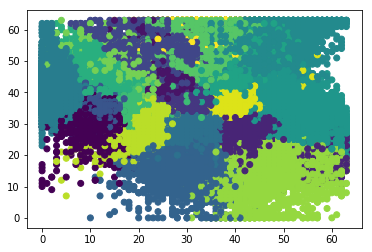

In [315]:
plt.scatter(trainDataSegmented[:,0],trainDataSegmented[:,1], c=k_means.labels_)  

In [316]:
# Agglomerative Clustering is another option
hierClustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')

## Create a histogram of cluster centers to use as an input into the classifier

In [317]:
def createHistograms(dataSegments, labels, fileIdentifiers, model, n_clusters):
    unique, segmentCounts = np.unique(fileIdentifiers, return_counts=True)
    numFiles = len(np.unique(fileIdentifiers))
    features = np.zeros(numFiles * (n_clusters + 1), dtype = int)
    features = features.reshape(numFiles, (n_clusters + 1))
    prevSegment = 0
    
    for i in range(len(np.unique(fileIdentifiers))):
        start = prevSegment
        end = prevSegment + segmentCounts[i]
        assignment = vq(dataSegments[start:end], model.cluster_centers_) # Create vector with each segment assigned to a given cluster
        assignmentArr = np.array(assignment[0])
        feature = np.zeros(n_clusters + 1, dtype = 'int')
        assignmentArr = np.array(assignment[0])

        for j in assignmentArr:
            features[i][j] += 1
    
        features[i][n_clusters] = labels[start]
    
        prevSegment = end
    return features

In [318]:
trainFeatures = createHistograms(trainDataSegmented, trainLabels, trainFileIdentifiers, k_means, n_clusters)
testFeatures = createHistograms(testDataSegmented, testLabels, testFileIdentifiers, k_means, n_clusters)

In [319]:
hist = np.zeros(14 * n_clusters, dtype = int)
hist = hist.reshape(14, n_clusters)

In [320]:
for i in range(0, 14):
    hist[i] = trainFeatures[trainFeatures[0:, 14] == i].sum(axis=0)[:-1]

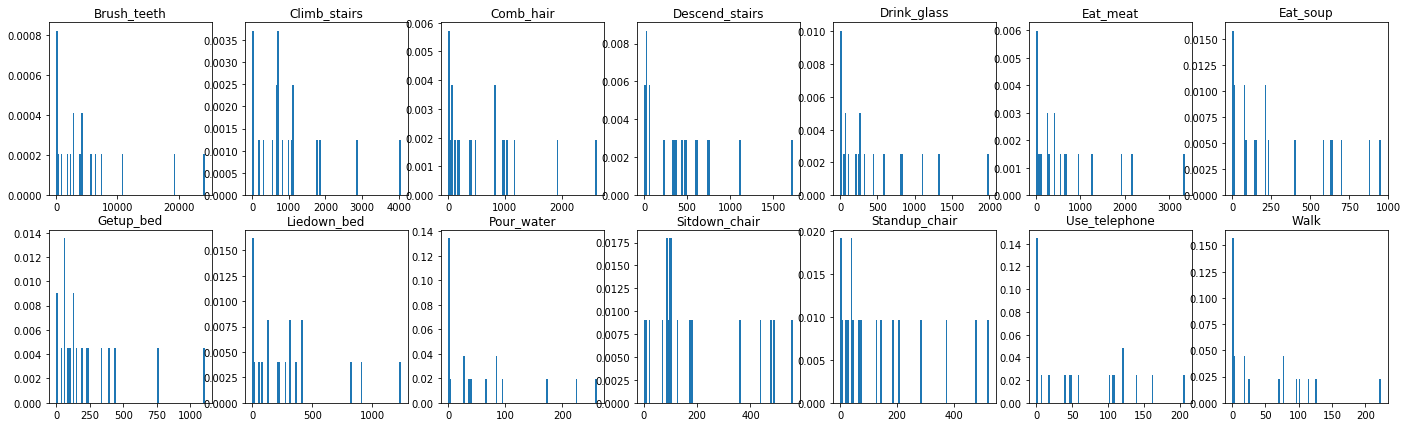

In [321]:
_, ax = plt.subplots(nrows=2, ncols=7, figsize=(24,7))
    
for i in range(0, 7):
    ax[0,i].set_title(hmpLabels[i])
    ax[0,i].hist(hist[i], density=True, bins=100)
    
for i in range(0, 7):
    ax[1,i].set_title(hmpLabels[i+7])
    ax[1,i].hist(hist[i+7], density=True, bins=100)    

In [322]:
#n, bins, patches = plt.hist(x=hist[0], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.15)
#plt.xlabel('Value')
#plt.ylabel('Frequency')
#plt.title(hmpLabels[0])

## Classification using Random Forest Classifier

In [358]:
randomForestClassifier = RandomForestClassifier(max_depth=32, random_state=8, n_estimators=200)

In [359]:
randomForestClassifier.fit(trainFeatures[0:, 0:n_clusters], trainFeatures[:, -1])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=32, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=8, verbose=0, warm_start=False)

In [360]:
prediction = randomForestClassifier.predict(testFeatures[0:, 0:n_clusters])

In [361]:
accuracy = accuracy_score(testFeatures[:, -1], prediction)

In [362]:
print("Classifier accuracy: " + str(round((accuracy * 100),2)) + "%")

Classifier accuracy: 81.65%


In [363]:
print(confusion_matrix(testFeatures[:, -1], prediction))

[[ 3  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 31  0  2  0  0  0  0  0  0  0  1  0  0]
 [ 0  0 10  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0 32  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 33  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  5  1  0  1  2  0  0]
 [ 0  0  0  0  0  0  0  0  0 33  0  0  0  0]
 [ 0  0  0  0  1  0  0  3  0  2 20  7  0  0]
 [ 0  0  0  0  0  0  0  2  0  1 11 20  0  0]
 [ 0  0  0  0  2  0  0  0  0  1  0  0  1  0]
 [ 0  4  0  0  0  0  0  1  0  0  0  0  0 28]]


# Results

## Page 1 (Experiment table)

Table listing the experiments carried out with the following columns. Size of the fixed length sample Overlap (0-X%) K-value Classifier Accuracy. 

We expect you to have tried at least 2 values of K and at least 2 different lengths of the windows for quantization.

Note: For K-means please also list if you used standard K-means or hierarchical.

In [268]:
clustersToTry = [4, 8, 16, 20, 25, 30, 40, 50]
segmentSizesToTry = [1, 4, 8, 32, 64]
inertiasBySegment = {}
accPerClusterNumAndSegmentSize = []
trainSize = 2/3

In [269]:
for segmentSize in tqdm(segmentSizesToTry):
    inertias = []    
    for n_clusters in clustersToTry:
        (trainDataSegmented, trainLabels, trainFileIdentifiers, testDataSegmented, testLabels, testFileIdentifiers) = segmentAndSplitData(trainSize, segmentSize, hmpData, hmpLabels, False)
        k_means_segmented = KMeans(n_clusters=n_clusters, random_state=0).fit(trainDataSegmented)
        trainFeatures = createHistograms(trainDataSegmented, trainLabels, trainFileIdentifiers, k_means_segmented, n_clusters)
        
        k_means = KMeans(n_clusters=n_clusters, random_state=0).fit(trainFeatures)
        inertias.append(k_means.inertia_)
        
        trainFeatures = createHistograms(trainDataSegmented, trainLabels, trainFileIdentifiers, k_means_segmented, n_clusters)
        testFeatures = createHistograms(testDataSegmented, testLabels, testFileIdentifiers, k_means_segmented, n_clusters)
        
        # Get accuracy
        randomForestClassifier = RandomForestClassifier(max_depth = 32, random_state = 0, n_estimators=10)
        randomForestClassifier.fit(trainFeatures[0:, 0:n_clusters], trainFeatures[:, -1])
        prediction = randomForestClassifier.predict(testFeatures[0:, 0:n_clusters])
        accuracy = accuracy_score(testFeatures[:, -1], prediction)
        acc = (accuracy_score(testFeatures[:, -1], prediction))*100
        acc = round(float(acc), 4)
        accPerClusterNumAndSegmentSize.append([n_clusters, segmentSize, acc])

    inertiasBySegment[segmentSize] = inertias



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [05:43<22:55, 343.95s/it]

 40%|████      | 2/5 [08:01<14:06, 282.14s/it]

 60%|██████    | 3/5 [09:07<07:14, 217.23s/it]

 80%|████████  | 4/5 [09:28<02:38, 158.31s/it]

100%|██████████| 5/5 [09:42<00:00, 114.94s/it]

In [271]:
accPerClusterNumAndSegmentSize = np.array(accPerClusterNumAndSegmentSize)
bestAccuracy = accPerClusterNumAndSegmentSize[accPerClusterNumAndSegmentSize[:,2].argsort()][-1]
print(f'Best accuracy of {bestAccuracy[2]}% with {bestAccuracy[0]} clusters and {bestAccuracy[1]} segments')

Best accuracy of 81.295% with 20.0 clusters and 1.0 segments


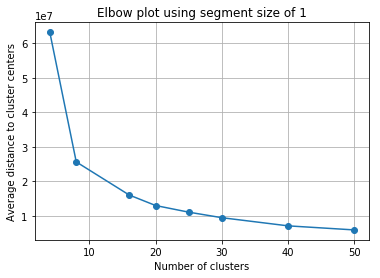

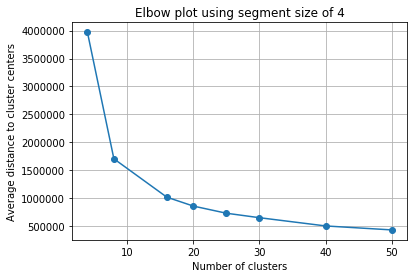

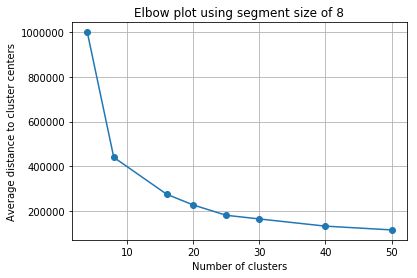

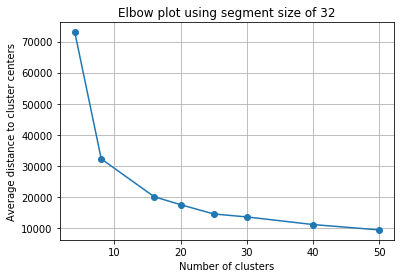

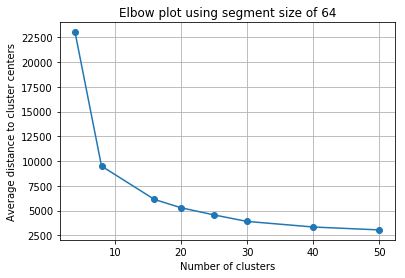

In [272]:
for segmentSize in inertiasBySegment:
    plt.plot(clustersToTry, inertiasBySegment[segmentSize], marker="o")
    plt.xlabel('Number of clusters')
    plt.ylabel('Average distance to cluster centers')
    plt.title('Elbow plot using segment size of ' + str(segmentSize))
    plt.grid(True)
    plt.show()

In [74]:
# print (np.matrix(accPerClusterNumAndSegmentSize))

In [273]:
xs = accPerClusterNumAndSegmentSize[:, 0]
ys = accPerClusterNumAndSegmentSize[:, 1]
zs = accPerClusterNumAndSegmentSize[:, 2]

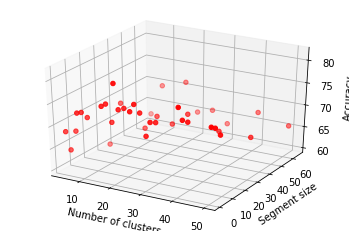

In [274]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs, ys, zs, c='r', marker='o')

ax.set_xlabel('Number of clusters')
ax.set_ylabel('Segment size')
ax.set_zlabel('Accuracy')

plt.show()

## Page 2 (Histograms)

Histograms of the mean quantized vector (Histogram of cluster centres like in the book) for each activity with the K value that gives you the highest accuracy.
(Please state the K value)

In [364]:
# fullFeatureSet = np.concatenate((trainFeatures, testFeatures))

In [365]:
print(f'Best accuracy of {bestAccuracy[2]}% with {bestAccuracy[0]} clusters and {bestAccuracy[1]} segments')

Best accuracy of 81.295% with 20.0 clusters and 1.0 segments


In [366]:
segmentSize = 1
n_clusters = 20

In [367]:
k_means = KMeans(n_clusters=n_clusters, random_state=0).fit(trainDataSegmented)

In [369]:
trainFeatures = createHistograms(trainDataSegmented, trainLabels, trainFileIdentifiers, k_means, n_clusters)
testFeatures = createHistograms(testDataSegmented, testLabels, testFileIdentifiers, k_means, n_clusters)

In [370]:
hist = np.zeros(14 * n_clusters, dtype = int)
hist = hist.reshape(14, n_clusters)

In [371]:
for i in range(0, 14):
    hist[i] = trainFeatures[trainFeatures[0:, 14] == i].sum(axis=0)[:-1]

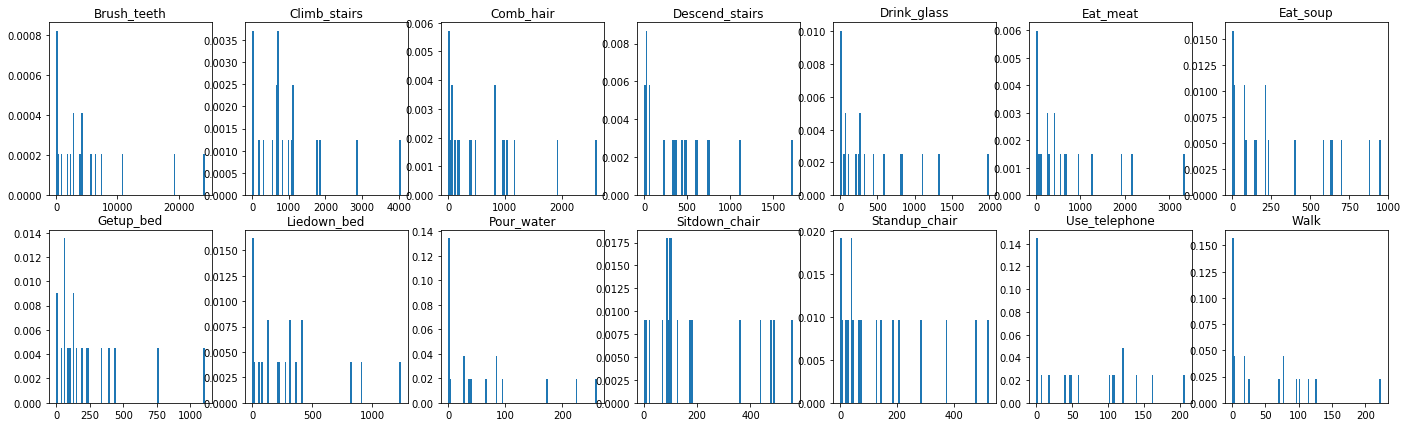

In [372]:
_, ax = plt.subplots(nrows=2, ncols=7, figsize=(24,7))
    
for i in range(0, 7):
    ax[0,i].set_title(hmpLabels[i])
    ax[0,i].hist(hist[i], density=True, bins=100)
    
for i in range(0, 7):
    ax[1,i].set_title(hmpLabels[i+7])
    ax[1,i].hist(hist[i+7], density=True, bins=100)    

## Page 3 Confusion matrix

In [373]:
# Class confusion matrix from the classifier that you used.
# Please make sure to label the row/colums of the matrix so that we know which row corresponds to what.

In [374]:
randomForestClassifier = RandomForestClassifier(max_depth=32, random_state=8, n_estimators=200)

In [375]:
randomForestClassifier.fit(trainFeatures[0:, 0:n_clusters], trainFeatures[:, -1])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=32, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=8, verbose=0, warm_start=False)

In [376]:
prediction = randomForestClassifier.predict(testFeatures[0:, 0:n_clusters])

In [377]:
accuracy = accuracy_score(testFeatures[:, -1], prediction)

In [378]:
print("Classifier accuracy: " + str(round((accuracy * 100),2)) + "%")

Classifier accuracy: 81.65%


In [379]:
print(confusion_matrix(testFeatures[:, -1], prediction))

[[ 3  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 31  0  2  0  0  0  0  0  0  0  1  0  0]
 [ 0  0 10  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0 32  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 33  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  5  1  0  1  2  0  0]
 [ 0  0  0  0  0  0  0  0  0 33  0  0  0  0]
 [ 0  0  0  0  1  0  0  3  0  2 20  7  0  0]
 [ 0  0  0  0  0  0  0  2  0  1 11 20  0  0]
 [ 0  0  0  0  2  0  0  0  0  1  0  0  1  0]
 [ 0  4  0  0  0  0  0  1  0  0  0  0  0 28]]
